In [1]:
### FL-MSSR ###


# This code provides a FLIM simulator for two independent, non-interacting fluorophores separated
# at a diffraction-limited distance, in particular, at the Sparrow limit (2*sigma) but the distance can be
# varied by the user.

# It generates the 2D FLIM image by convolving the lifetime-modulated intensity of the fluorophores with a
# gaussian PSF.

# Moreover, this simulation includes the phasor analysis of the image to visualize the fluorescence lifetime distribution of
# the fluorophores interacting with the PSF.

# Finally, with the insertion of the MSSR code (https://github.com/MSSRSupport/MSSR) one can perform the resolution enhancing of
# the generated image[1]. For comparison, it performs deconvolution by Wiener and Richardson-Lucy (RL) algorithms.

# The variables that can be changed by the user are:

# 1. The fluorescence lifetimes of both fluorophores
# 2. The distance (in terms of sigma) at which the fluorophores are to be positioned
# 3. The period of the exciting light (thus modifying the time bin of the fluorescence decay measurement)
# 4. The number of MSSR orders (from 0 to 3)
# 5. The number of iteration for the RL deconvolution algorithm (by default we use 2)





# [1] Torres-García, E., Pinto-Cámara, R., Linares, A., Martínez, D., Abonza, V., Brito-Alarcón, E., ... & Guerrero, A. 
#     “Extending resolution within a single imaging frame”. Nature Communications, 13(1), 7452, 2022


In [2]:
####   Libraries   ####

import numpy as np
import math
import matplotlib.pyplot as plt 
from scipy.signal import deconvolve
from scipy.signal import wiener
from skimage import restoration
from numpy import *
from matplotlib import colors
from scipy import ndimage, misc
from scipy import signal
from PIL import Image 
from matplotlib import cm
%matplotlib inline

In [3]:
####   MSSR code   ####

#Bicubic Interpolation
def bicInter(img, amp, mesh):
	width, height = img.shape
	y=np.linspace(1, width, width)
	x=np.linspace(1, height, height)
	imgInter=interpolate.interp2d(x, y, img, kind='cubic')
	y2=np.linspace(1, width, width*amp)
	x2=np.linspace(1, height, height*amp)
	Z2 = imgInter(x2, y2)
	if mesh:
		Z2 = meshing(Z2, amp)
	return Z2

#Fourier Interpolation
def ftInterp(img, amp, mesh):
	width, height = img.shape
	mdX = math.ceil(width/2) + 1
	mdY = math.ceil(height/2) + 1 
	
	extraBorder = math.ceil(amp/2)
	Nwidth = (width*amp) + extraBorder
	Nheight = (height*amp) + extraBorder
	
	lnX = len(np.arange((mdX),width))
	lnY = len(np.arange((mdY),height))
	
	imgFt = np.fft.fft2(img)
	imgFt = imgFt * (Nwidth/width) * (Nheight/height)
#	imgFt = imgFt * amp * amp
	
	fM = np.zeros((Nwidth, Nheight), dtype=complex)
	fM[0:mdX, 0:mdY] = imgFt[0:mdX, 0:mdY]; #izq sup cuadrante
	fM[0:mdX, (Nheight-lnY):Nheight] = imgFt[0:mdX, (mdY):height]; #der sup cuadrante
	fM[(Nwidth-lnX):Nwidth, 0:mdY] = imgFt[(mdX):width, 0:mdY]; #izq inf cuadrante
	fM[(Nwidth-lnX):Nwidth, (Nheight-lnY):Nheight] = imgFt[(mdX):width, (mdY):height]; #der inf cuadrante

	Z2 = (np.fft.ifft2(fM)).real
	Z2 = Z2[0:(width*amp), 0:(height*amp)]
	if mesh:
		Z2 = meshing(Z2, amp)
	return Z2

#Mesh compensation
def meshing(img, amp):
    width, height = img.shape
    desp = math.ceil(amp/2)
    imgPad = np.pad(img, desp, 'symmetric')
    imgS1 = imgPad[0:width, desp:height+desp]
    imgS2 = imgPad[(desp*2):width+(desp*2), desp:height+desp]
    imgS3 = imgPad[desp:width+desp, 0:height]
    imgS4 = imgPad[desp:width+desp, (desp*2):height+(desp*2)]
    imgF = (img + imgS1 + imgS2 + imgS3 + imgS4) / 5
    return imgF

#Spatial MSSR
def sfMSSR(img, fwhm, amp, order, mesh = True, ftI = False, intNorm = True):
	hs = round(0.5*fwhm*amp)
	if hs < 1:
		hs = 1
	maxValueImgOr = (max(map(max, img)))
	if(amp > 1 and not ftI):
		img = bicInter(img, amp, mesh)
	elif(amp > 1 and ftI):
		img = ftInterp(img, amp, mesh)
	width, height = img.shape
	xPad = np.pad(img, hs, 'symmetric')
	M = np.zeros((width,height))
	for i in range(-hs, hs+1):
		for j in range(-hs, hs+1):
			if i!=0 or j!=0:
				xThis = xPad[hs+i:width+hs+i, hs+j:height+hs+j]
				M = np.maximum(M, np.absolute(img-xThis))

	weightAccum = np.zeros((width,height))
	yAccum = np.zeros((width,height))

	for i in range(-hs, hs+1):
		for j in range(-hs, hs+1):
			if i!=0 or j!=0:
				spatialkernel = np.exp(-(pow(i,2)+pow(j,2))/pow((hs),2))
				xThis = xPad[hs+i:width+hs+i, hs+j:height+hs+j]
				xDiffSq0 = pow((img-xThis)/M,2)
				intensityKernel = np.exp(-xDiffSq0)

				weightThis = spatialkernel*intensityKernel
				weightAccum = weightAccum + weightThis
				yAccum = yAccum + (xThis*weightThis)

	MS = img - (yAccum/weightAccum)
	MS[MS < 0] = 0
	MS[np.isnan(MS)] = 0

	I3 = MS/(max(map(max, MS)))
	x3 = img/(max(map(max, img)))
	for i in range(order):
		I4 = x3 - I3
		I5 = max(map(max, I4)) - I4
		I5 = I5/max(map(max, I5))
		I6 = I5*I3
		I7 = I6/max(map(max, I6))
		x3 = I3
		I3 = I7
	I3[np.isnan(I3)] = 0
	if intNorm:
		IMSSR = I3*img
	else:
		IMSSR = I3
	return IMSSR

#Temporal MSSR
def tMSSR(img_layer, fwhm, amp, order, mesh = True, ftI = False, intNorm = True):
	img=np.array(img_layer.data)
	nFrames, width, height = img.shape
	imgMSSR = np.zeros((nFrames,width*amp,height*amp))
	for nI in range(nFrames):
		print("Image " + str(nI+1))
		imgMSSR[nI, :, :] = sfMSSR(img[nI], fwhm, amp, order, mesh, ftI, intNorm)
	return imgMSSR

#Mean
def tMean(img):
	return np.mean(img, 0)

#Variance
def tVar(img):
	return np.var(img, 0)

#Temporal Product Mean
def TPM(img):
    nFrames, width, height = img.shape
    SumTPM = np.zeros((width,height))
    iTPM = np.zeros((width,height))
    for i in range(nFrames):
        SumTPM = SumTPM + img[i]
    for i in range(nFrames):
        iTPM = iTPM + (SumTPM * img[i])
    return iTPM

#Auto-Cummulants
def TRAC(img, k):
    nFrames, width, height = img.shape
    avg = np.mean(img, 0)
    d0 = np.absolute(img - avg)
    d1 = d0[1:nFrames, :, :]
    d2 = d0[2:nFrames, :, :]
    d3 = d0[3:nFrames, :, :]
    if k == 2:
        trac = np.mean(d0[1:nFrames, :, :]*d1,0)
    elif k == 3:
        trac = np.mean(d0[2:nFrames, :, :]*d1[1:nFrames, :, :]*d2,0)
    else:
        t1 = np.mean(d0[3:nFrames, :, :]*d1[2:nFrames, :, :]*d2[1:nFrames, :, :]*d3,0)
        t2 = np.mean(d0[3:nFrames, :, :]*d1[2:nFrames, :, :],0)*np.mean(d2[1:nFrames, :, :]*d3,0)
        t3 = np.mean(d0[3:nFrames, :, :]*d2[1:nFrames, :, :],0)*np.mean(d1[2:nFrames, :, :]*d3,0)
        t4 = np.mean(d0[3:nFrames, :, :]*d3,0)*np.mean(d1[2:nFrames, :, :]*d2[1:nFrames, :, :],0)
        trac = np.absolute(t1-t2-t3-t4)
    return trac

#Empirical cumulative distribution function
def ecdf(data):
	""" Compute ECDF """
	data = np.reshape(data, -1)
	x = np.sort(data)
	n = len(x)
	y = np.arange(1, n+1) / n
	return(x,y)

#Exclude Outliers
def excOutliers(data, th):
	th = (100 - th)/100
	x, f = ecdf(data)
	found = np.where(f > th)
	mnX = x[found[0][0]];
	data = np.where(data >= mnX, mnX, data)
	return data

Enter a period for the exciatation source in ns (100, 500, 1000 or 5000):  50
Enter a fluorescence lifetime, τ_1, in ns (from 0.01 to 25.82, two decimal figures allowed):  1
Enter a fluorescence lifetime, τ_2, in ns (from 0.01 to 25.82, two decimal figures allowed):  3


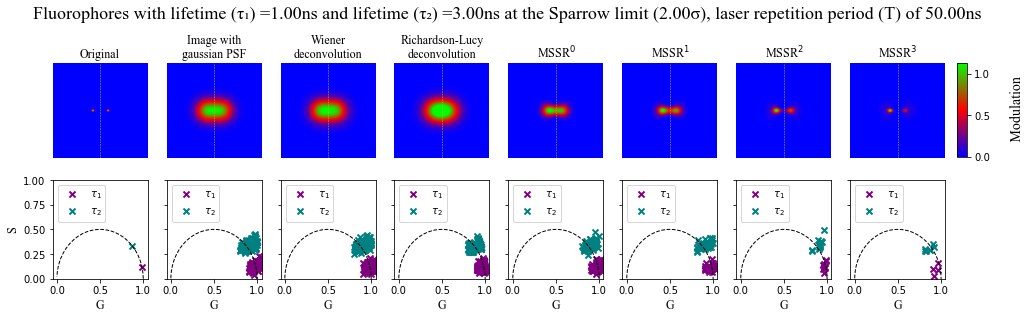

The value of Mod(τ_1) as (ACem1/DCem1)/(ACex/DCex) is 0.9922 with an error of 0.0000 %
which gives a value of τ_1: 1.0000 ns with an error of 0.001381 %

The value of Mod(τ_2) as (ACem2/DCem2)/(ACex/DCex) is 0.9356 with an error of 0.0136 %
which gives a value of τ_2: 3.0033 ns with an error of 0.109034 %

τ_2 is 3.00 times larger than τ_1 and its Modulation, at T = 50.00ns ,is 1.0605 times shorter.


In [15]:
####   Functions for Gaussian-like PSF   ####

def generate_gauss(sigma, len_, centerY, centerX):
    Y = np.arange(-len_, len_+1)
    R,C = np.meshgrid(Y, Y)
    I = gaussC(R, C, sigma, [centerY, centerX])
    return I

def gaussC(x, y, sigma, center):
    xc = center[0]
    yc = center[1]
    exponent = ((x-xc)**2 + (y-yc)**2)/(2*(sigma**2))
    val = (np.exp(-exponent))
    return val

rIm = 1.33                                 # Medium's refraction index
rIo = 1.515                                # Oil's refraction index
NA = 1.4                                   # Numerical Aperture of the Objective Lens
lambda_ = 600                              # Emission Wavelength
pxsz = 11.7                                # Pixel size
len_ = 63.5                                # Half the number of pixels to define the image size
NA = NA * rIm/rIo                          # NA correction by the refraction index ratio
fwhm = 0.5746*lambda_/NA                   # Full Width at Half Maximum
ratioSigFWHM = 2*np.sqrt(2*np.log(2))      # FWHM to sigma ratio constant
sigma = ((fwhm/ratioSigFWHM)/pxsz)         # PSF sigma in pixels. Estimated from experimental parameters
center = np.arange(0, 4.01, 0.01)          # Coeficients to define the distance between the fluorophores

####   Simulation image of two fluorophores   ####

##   FD-FLIM simulation   ##

#   Function E(t)   #

E_0 = 1                                    # Steady-state intensity. Arbitrary units
E_w = 1                                    # Amplitude of the time-varying intensity. Arbitrary units

T = float(input('Enter a period for the exciatation source in ns (100, 500, 1000 or 5000): '))       
                                           # Period of repetition of the excitation light. Time in nanoseconds 
                                           # Changing the value of T will affect the resolution of the lifetimes measured. i.e. 
                                           # for fluorophores with lifetimes in the range of 0.0-5.55 ns,  T = 100
                                           # for fluorophores with lifetimes in the range of 0.0-25.82 ns, T = 500
                                           # for fluorophores with lifetimes in the range of 0.0-51.15 ns, T = 1000
                                           # for fluorophores with lifetimes in the range of 0.0-253.81ns, T = 5000
                        
w = (2*np.pi)/T                            # Angular frequency of excitation light.
t = np.arange(0, T, 1)                     # Time bin of the oscillation from the excitation light. It defines the number of cycles to be used
phi_E = 0                                  # Phase of the excitation light. Angle in radians
E_t = E_0 + E_w*np.cos(w*t + phi_E)        # Intensity modulation function for the excitation light.

#   Emission F(t)   #

# The fluorescence emission at time , t,  is
# F(t) = E_0*a_s*tau_s + E_w*a_s*tau_s*Ms*cos(w*t + phi_E - phi_F)

a_s = 1.0                                  # fractional number from 0.0 to 1.0 indicating how much of the signal
                                           # corresponds to a specific fluorophore emission 
    
tau_1 = float(input('Enter a fluorescence lifetime, \u03C4_1, in ns (from 0.01 to 25.82, two decimal figures allowed): '))  # fluorescence lifetime in ns
tau_2 = float(input('Enter a fluorescence lifetime, \u03C4_2, in ns (from 0.01 to 25.82, two decimal figures allowed): '))  # fluorescence lifetime in ns

Ms_1 = 1 / np.sqrt(1 + (w*tau_1)**2)       # Modulation of the fluorescecne signal for the fluorophore 1
Ms_2 = 1 / np.sqrt(1 + (w*tau_2)**2)       # Modulation of the fluorescence signal for the fluorophore 2
phi_F1 = np.arctan(w*tau_1)                # Phase delay in rad from the fluorescence signal of the fluorophore 1
phi_F2 = np.arctan(w*tau_2)                # Phase delay in rad from the fluorescence signal of the fluorophore 2

#   Normalized version of F(t)   #

norm_F1 = 1 + Ms_1*np.cos(w*t + phi_E - phi_F1)                 
norm_F2 = 1 + Ms_2*np.cos(w*t + phi_E - phi_F2)                 

#   Modulation and phase delay from AC/DC ratio   #

max_E = max(E_t)
mean_E = np.mean(E_t)
max_F1 = max(norm_F1)
mean_F1 = np.mean(norm_F1)
max_F2 = max(norm_F2)
mean_F2 = np.mean(norm_F2)

#   AC lines   #

ACex = max_E - mean_E
ACem1 = max_F1 - mean_F1
ACem2 = max_F2 - mean_F2

#   DC lines   #

DCex = mean_E
DCem1 = mean_F1
DCem2 = mean_F2

#   AC/DC ratio to calculate the modulation shift   #

Mod1 = (ACem1/DCem1)/(ACex/DCex)                   # Modulation of fluorophore 1
tau_mod1 = (1/w)*np.sqrt((1/Mod1**2)-1)            # Modulation lifetime of fluorophore 1
Mod2 = (ACem2/DCem2)/(ACex/DCex)                   # Modulation of fluorophore 2
tau_mod2 = (1/w)*np.sqrt((1/Mod2**2)-1)            # Modulation lifetime of fluorophore 2

#   Error calculation   #

Mod1_err = (abs(Ms_1-Mod1)/Ms_1)*100               # Error calculation of Modulation 1
tau1_err = (abs(tau_1-tau_mod1)/tau_1)*100         # Error calculation of Modulation lifetime 1
Mod2_err = (abs(Ms_2-Mod2)/Ms_2)*100               # Error calculation of Modulation 2
tau2_err = (abs(tau_2-tau_mod2)/tau_2)*100         # Error calculation of Modulation lifetime 2

rtau = tau_mod2/tau_mod1                           # Fluorescence lifetimes ratio
rMod = Mod1/Mod2                                   # Modulations ratio

#   Calculation of phase delay (phi) using cross-correlation   #

corr1 = signal.correlate(E_t - abs(mean_E), norm_F1 - abs(mean_F1), mode="full")          # cross-correlation between E(t) and the normalized F(t) from the fluorophore 1
lags1 = signal.correlation_lags(E_t.size, norm_F1.size, mode="full")
corr2 = signal.correlate(E_t - abs(mean_E), norm_F2 - abs(mean_F2), mode="full")          # cross-correlation between E(t) and the normalized F(t) from the fluorophore 2
lags2 = signal.correlation_lags(E_t.size, norm_F2.size, mode="full")

# lags: Returns an array containing cross-correlation lag/displacement indices. 
# Indices can be indexed with the np.argmax of the correlation to return the lag/displacement.

theta1 = lags1[np.argmax(corr1)]                  # Phase angle of the lag from the correlation for the fluorophore 1 
tan_theta1 = np.tan(theta1)
tau_theta1 = tan_theta1/w                         # Phase lifetime of the fluorophore 1
theta2 = lags2[np.argmax(corr2)]                  # Phase angle of the lag from the correlation for the fluorophore 2
tan_theta2 = np.tan(theta2)
tau_theta2 = tan_theta2/w                         # Phase lifetime of the fluorophore 2

#   Error calculation   #

phi1_err = (abs(phi_F1-theta1)/phi_F1)*100           # Phase lifetime of fluorophore 1
tau1_phi_err = (abs(tau_1-tau_theta1)/tau_1)*100     # Error calculation of Phase lifetime 1
delta_phi1 = phi_F1-theta1
phi2_err = (abs(phi_F2-theta2)/phi_F2)*100           # Phase lifetime of fluorophore 2
tau2_phi_err = (abs(tau_2-tau_theta2)/tau_2)*100     # Error calculation of Phase lifetime 2
delta_phi2 = phi_F2-theta2

#From the above, the most important part is the Mod value which is going to be convolved with the normalized gaussian PSF

##   Generation of FLIM images   ##

#   Two fluorophores with no PSF (Original)   #

center = 2.0
ImgRo = generate_gauss(1.0, len_, (sigma*center)/2, 0)      # Right Gaussian PSF, with parameter sigma = 1.0 to draw a pixel-sized point
ImgLo = generate_gauss(1.0, len_, -(sigma*center)/2, 0)     # Left Guassian PSF, with parameter sigma = 1.0 to draw a pixel-sized point
ImgRo_Mod = ImgRo*Mod2                                      # Convolution of the Lifetime-modulated fluorescence with the gaussian PSF at the right
ImgLo_Mod = ImgLo*Mod1                                      # Convolution of the Lifetime-modulated fluorescence with the gaussian PSF at the left    
ImgBo = ImgRo_Mod + ImgLo_Mod                               # Full image
        
#   Two fluorophores convolved with gaussian PSF   #
        
center = 2.0
ImgR = generate_gauss(sigma, len_, (sigma*center)/2, 0)     # Right Gaussian PSF
ImgL = generate_gauss(sigma, len_, -(sigma*center)/2, 0)    # Left Gaussian PSF
ImgR_Mod = ImgR*Mod2                                        # Convolution of the Lifetime-modulated fluorescence with the gaussian PSF at the right
ImgL_Mod = ImgL*Mod1                                        # Convolution of the lifetime-modulated fluorescence with the gaussian PSF at the left 
ImgB = ImgR_Mod + ImgL_Mod                                  # Full image

##   Deconvolution analysis   ##

#   Wiener deconvolution   #

ImgB_wiener = wiener(ImgB, (int(sigma), int(sigma)))

#   Richardson-Lucy deconvolution   #

PSF = generate_gauss(sigma, len_, 0, 0)                           # Generate PSF with same dimensions as ImgB
ImgB_RL = restoration.richardson_lucy(ImgB, PSF, num_iter = 2)    # Richardson-Lucy restoration

#   sf-MSSR   #

ImgB_MSSR0 = sfMSSR(ImgB, 3*sigma, 1.0, 0, mesh = True, ftI = False, intNorm = True) # mssr_order = 0
ImgB_MSSR1 = sfMSSR(ImgB, 3*sigma, 1.0, 1, mesh = True, ftI = False, intNorm = True) # mssr_order = 1
ImgB_MSSR2 = sfMSSR(ImgB, 3*sigma, 1.0, 2, mesh = True, ftI = False, intNorm = True) # mssr_order = 2
ImgB_MSSR3 = sfMSSR(ImgB, 3*sigma, 1.0, 3, mesh = True, ftI = False, intNorm = True) # mssr_order = 3

##   Phasor plot from images   ##
        
#   Phasor plot from Original   #
        
# Calculating G and S #
ImgBoG1 = Mod1*np.cos(theta1 - delta_phi1)
ImgBoS1 = Mod1*np.sin(theta1 - delta_phi1)
ImgBoG2 = Mod2*np.cos(theta2 - delta_phi2)
ImgBoS2 = Mod2*np.sin(theta2 - delta_phi2)
# Unitary Circle #
theta = np.arange(0.0, np.pi, 0.1)
cos = np.cos(theta)
sen = np.sin(theta)       

#   Pixel-by-pixel analysis and Phasor plot from ImgB    #

height, width = ImgB.shape           # Get image dimensions
# Set the desired size of the matrix
rows = 128
cols = 64
# Set the desired center of the lifetime distribution within the phasor plot
phase1 = theta1 - delta_phi1
phase2 = theta2 - delta_phi2
# Generate a matrix with random values from a normal distribution centered at 'center'
phase1_matrix = np.random.normal(loc=phase1, scale= 0.003*sigma,  size=(rows, cols))
phase2_matrix = np.random.normal(loc=phase2, scale= 0.003*sigma,  size=(rows, cols))
sine1 = np.sin(phase1_matrix)                # creating sine wave for phasor approach
sine2 = np.sin(phase2_matrix)                # creating sine wave for phasor approach
cosine1 = np.cos(phase1_matrix)              # creating cosine wave for phasor approach
cosine2 = np.cos(phase2_matrix)              # creating cosine wave for phasor approach
# Create empty arrays to store the results
phasor1 = np.zeros((height, int(width/2)))
phasor2 = np.zeros((height, int(width/2)))
ImgBG1 = np.zeros((height, int(width/2)))
ImgBS1 = np.zeros((height, int(width/2)))
ImgBG2 = np.zeros((height, int(width/2)))
ImgBS2 = np.zeros((height, int(width/2)))
# Unitary Circle #
theta = np.arange(0.0, np.pi, 0.1)
cos = np.cos(theta)
sen = np.sin(theta)
# Phasor plot
for y in range(0,height):
    for x in range(0,int(width/2)):
        G2 = ImgB[y, x] * cosine2
        S2 = ImgB[y, x] * sine2
        if G2[y,x] <= 0.8:
            G2[y,x] = 2
        elif G2[y,x] > 1.0:
            G2[y,x] = 2
        #if S2[y,x] <= 0.25:
            #S2[y,x] = 2
        #elif S2[y,x] > 0.6:
            #S2[y,x] =2
        ImgBG2[y,x] = phasor2[y,x] + G2[y,x]
        ImgBS2[y,x] = phasor2[y,x] + S2[y,x]

for y in range(0, height):
    for x in range(0,int(width/2)):
        G1 = ImgB[y, x] * cosine1
        S1 = ImgB[y, x] * sine1
        if G1[y,x] <= 0.9:
            G1[y,x] = 2
        elif G1[y,x] > 1.05:
            G1[y,x] = 2
        #if S1[y,x] <= 0.2:
            #S1[y,x] = 2
        ImgBG1[y,x] = phasor1[y,x] + G1[y,x]
        ImgBS1[y,x] = phasor1[y,x] + S1[y,x]

#   Pixel-by-pixel analysis and Phasor plot from ImgB_wiener   #
        
height, width = ImgB_wiener.shape    # Get image dimensions
# Set the desired size of the matrix
rows = 128
cols = 64
# Set the desired center of the lifetime distribution within the phasor plot
phase1 = theta1 - delta_phi1
phase2 = theta2 - delta_phi2
# Generate a matrix with random values from a normal distribution centered at 'center'
phase1_matrix = np.random.normal(loc=phase1, scale= 0.003*sigma,  size=(rows, cols))
phase2_matrix = np.random.normal(loc=phase2, scale= 0.003*sigma,  size=(rows, cols))
sine1 = np.sin(phase1_matrix)               # creating sine wave for phasor approach
sine2 = np.sin(phase2_matrix)               # creating sine wave for phasor approach
cosine1 = np.cos(phase1_matrix)             # creating cosine wave for phasor approach
cosine2 = np.cos(phase2_matrix)             # creating cosine wave for phasor approach
# Create empty arrays to store the results
phasor1 = np.zeros((height, int(width/2)))
phasor2 = np.zeros((height, int(width/2)))
ImgB_wienerG1 = np.zeros((height, int(width/2)))
ImgB_wienerS1 = np.zeros((height, int(width/2)))
ImgB_wienerG2 = np.zeros((height, int(width/2)))
ImgB_wienerS2 = np.zeros((height, int(width/2)))
# Unitary Circle #
theta = np.arange(0.0, np.pi, 0.1)
cos = np.cos(theta)
sen = np.sin(theta)
# Phasor plot
for y in range(0,height):
    for x in range(0,int(width/2)):
        G2 = ImgB_wiener[y, x] * cosine2
        S2 = ImgB_wiener[y, x] * sine2
        if G2[y,x] <= 0.8:
            G2[y,x] = 2
        elif G2[y,x] > 1.0:
            G2[y,x] = 2
        #if S2[y,x] <= 0.25:
            #S2[y,x] = 2
        #elif S2[y,x] > 0.6:
            #S2[y,x] =2
        ImgB_wienerG2[y,x] = phasor2[y,x] + G2[y,x]
        ImgB_wienerS2[y,x] = phasor2[y,x] + S2[y,x]

for y in range(0, height):
    for x in range(0,int(width/2)):
        G1 = ImgB_wiener[y, x] * cosine1
        S1 = ImgB_wiener[y, x] * sine1
        if G1[y,x] <= 0.9:
            G1[y,x] = 2
        elif G1[y,x] > 1.05:
            G1[y,x] = 2
        #if S1[y,x] <= 0.2:
            #S1[y,x] = 2
        ImgB_wienerG1[y,x] = phasor1[y,x] + G1[y,x]
        ImgB_wienerS1[y,x] = phasor1[y,x] + S1[y,x]


#   Pixel-by-pixel analysis and Phasor plot from ImgB    # ImgB_RL

height, width = ImgB_RL.shape         # Get image dimensions
# Set the desired size of the matrix
rows = 128
cols = 64
# Set the desired center of the lifetime distribution within the phasor plot
phase1 = theta1 - delta_phi1
phase2 = theta2 - delta_phi2
# Generate a matrix with random values from a normal distribution centered at 'center'
phase1_matrix = np.random.normal(loc=phase1, scale= 0.003*sigma,  size=(rows, cols))
phase2_matrix = np.random.normal(loc=phase2, scale= 0.003*sigma,  size=(rows, cols))
sine1 = np.sin(phase1_matrix)                # creating sine wave for phasor approach
sine2 = np.sin(phase2_matrix)                # creating sine wave for phasor approach
cosine1 = np.cos(phase1_matrix)              # creating cosine wave for phasor approach
cosine2 = np.cos(phase2_matrix)              # creating cosine wave for phasor approach
# Create empty arrays to store the results
phasor1 = np.zeros((height, int(width/2)))
phasor2 = np.zeros((height, int(width/2)))
ImgB_RLG1 = np.zeros((height, int(width/2)))
ImgB_RLS1 = np.zeros((height, int(width/2)))
ImgB_RLG2 = np.zeros((height, int(width/2)))
ImgB_RLS2 = np.zeros((height, int(width/2)))
# Unitary Circle #
theta = np.arange(0.0, np.pi, 0.1)
cos = np.cos(theta)
sen = np.sin(theta)
# Phasor plot
for y in range(0,height):
    for x in range(0,int(width/2)):
        G2 = ImgB_RL[y, x] * cosine2
        S2 = ImgB_RL[y, x] * sine2
        if G2[y,x] <= 0.8:
            G2[y,x] = 2
        elif G2[y,x] > 1.0:
            G2[y,x] = 2
        #if S2[y,x] <= 0.25:
            #S2[y,x] = 2
        #elif S2[y,x] > 0.6:
            #S2[y,x] =2
        ImgB_RLG2[y,x] = phasor2[y,x] + G2[y,x]
        ImgB_RLS2[y,x] = phasor2[y,x] + S2[y,x]

for y in range(0, height):
    for x in range(0,int(width/2)):
        G1 = ImgB_RL[y, x] * cosine1
        S1 = ImgB_RL[y, x] * sine1
        if G1[y,x] <= 0.9:
            G1[y,x] = 2
        elif G1[y,x] > 1.05:
            G1[y,x] = 2
        #if S1[y,x] <= 0.2:
            #S1[y,x] = 2
        ImgB_RLG1[y,x] = phasor1[y,x] + G1[y,x]
        ImgB_RLS1[y,x] = phasor1[y,x] + S1[y,x]


#   Pixel-by-pixel analysis and Phasor plot from ImgB    #

height, width = ImgB_MSSR0.shape     # Get image dimensions
# Set the desired size of the matrix
rows = 128
cols = 64
# Set the desired center of the lifetime distribution within the phasor plot 
phase1 = theta1 - delta_phi1
phase2 = theta2 - delta_phi2
# Generate a matrix with random values from a normal distribution centered at 'center'
phase1_matrix = np.random.normal(loc=phase1, scale= 0.003*sigma,  size=(rows, cols))
phase2_matrix = np.random.normal(loc=phase2, scale= 0.003*sigma,  size=(rows, cols))
sine1 = np.sin(phase1_matrix)               # creating sine wave for phasor approach
sine2 = np.sin(phase2_matrix)               # creating sine wave for phasor approach
cosine1 = np.cos(phase1_matrix)             # creating cosine wave for phasor approach
cosine2 = np.cos(phase2_matrix)             # creating cosine wave for phasor approach
# Create empty arrays to store the results
phasor1 = np.zeros((height, int(width/2)))
phasor2 = np.zeros((height, int(width/2)))
ImgB_MSSR0G1 = np.zeros((height, int(width/2)))
ImgB_MSSR0S1 = np.zeros((height, int(width/2)))
ImgB_MSSR0G2 = np.zeros((height, int(width/2)))
ImgB_MSSR0S2 = np.zeros((height, int(width/2)))
# Unitary Circle #
theta = np.arange(0.0, np.pi, 0.1)
cos = np.cos(theta)
sen = np.sin(theta)
# Phasor plot
for y in range(0,height):
    for x in range(0,int(width/2)):
        G2 = ImgB_MSSR0[y, x] * cosine2
        S2 = ImgB_MSSR0[y, x] * sine2
        if G2[y,x] <= 0.8:
            G2[y,x] = 2
        elif G2[y,x] > 1.0:
            G2[y,x] = 2
        #if S2[y,x] <= 0.25:
            #S2[y,x] = 2
        #elif S2[y,x] > 0.6:
            #S2[y,x] =2
        ImgB_MSSR0G2[y,x] = phasor2[y,x] + G2[y,x]
        ImgB_MSSR0S2[y,x] = phasor2[y,x] + S2[y,x]

for y in range(0, height):
    for x in range(0,int(width/2)):
        G1 = ImgB_MSSR0[y, x] * cosine1
        S1 = ImgB_MSSR0[y, x] * sine1
        if G1[y,x] <= 0.9:
            G1[y,x] = 2
        elif G1[y,x] > 1.05:
            G1[y,x] = 2
        #if S1[y,x] <= 0.2:
            #S1[y,x] = 2
        ImgB_MSSR0G1[y,x] = phasor1[y,x] + G1[y,x]
        ImgB_MSSR0S1[y,x] = phasor1[y,x] + S1[y,x]

#   Pixel-by-pixel analysis and Phasor plot from ImgB_MSSR1   #

height, width = ImgB_MSSR1.shape      # Set the desired size of the matrix
# Set the desired size of the matrix
rows = 128
cols = 64
# Set the desired center of the lifetime distribution within the phasor plot
phase1 = theta1 - delta_phi1
phase2 = theta2 - delta_phi2
# Generate a matrix with random values from a normal distribution centered at 'center'
phase1_matrix = np.random.normal(loc=phase1, scale= 0.003*sigma,  size=(rows, cols))
phase2_matrix = np.random.normal(loc=phase2, scale= 0.003*sigma,  size=(rows, cols))
sine1 = np.sin(phase1_matrix)               # creating sine wave for phasor approach
sine2 = np.sin(phase2_matrix)               # creating sine wave for phasor approach
cosine1 = np.cos(phase1_matrix)             # creating cosine wave for phasor approach
cosine2 = np.cos(phase2_matrix)             # creating cosine wave for phasor approach
# Create empty arrays to store the results
phasor1 = np.zeros((height, int(width/2)))
phasor2 = np.zeros((height, int(width/2)))
ImgB_MSSR1G1 = np.zeros((height, int(width/2)))
ImgB_MSSR1S1 = np.zeros((height, int(width/2)))
ImgB_MSSR1G2 = np.zeros((height, int(width/2)))
ImgB_MSSR1S2 = np.zeros((height, int(width/2)))
# Unitary Circle #
theta = np.arange(0.0, np.pi, 0.1)
cos = np.cos(theta)
sen = np.sin(theta)
# Phasor plot
for y in range(0,height):
    for x in range(0,int(width/2)):
        G2 = ImgB_MSSR1[y, x] * cosine2
        S2 = ImgB_MSSR1[y, x] * sine2
        if G2[y,x] <= 0.8:
            G2[y,x] = 2
        elif G2[y,x] > 1.0:
            G2[y,x] = 2
        #if S2[y,x] <= 0.25:
            #S2[y,x] = 2
        #elif S2[y,x] > 0.6:
            #S2[y,x] =2
        ImgB_MSSR1G2[y,x] = phasor2[y,x] + G2[y,x]
        ImgB_MSSR1S2[y,x] = phasor2[y,x] + S2[y,x]

for y in range(0, height):
    for x in range(0,int(width/2)):
        G1 = ImgB_MSSR1[y, x] * cosine1
        S1 = ImgB_MSSR1[y, x] * sine1
        if G1[y,x] <= 0.9:
            G1[y,x] = 2
        elif G1[y,x] > 1.05:
            G1[y,x] = 2
        #if S1[y,x] <= 0.2:
            #S1[y,x] = 2
        ImgB_MSSR1G1[y,x] = phasor1[y,x] + G1[y,x]
        ImgB_MSSR1S1[y,x] = phasor1[y,x] + S1[y,x]

#   Pixel-by-pixel analysis and Phasor plot from ImgB_MSSR2   #

height, width = ImgB_MSSR2.shape     # Get image dimensions
# Set the desired size of the matrix
rows = 128
cols = 64
# Set the desired center of the lifetime distribution within the phasor plot
phase1 = theta1 - delta_phi1
phase2 = theta2 - delta_phi2
# Generate a matrix with random values from a normal distribution centered at 'center'
phase1_matrix = np.random.normal(loc=phase1, scale= 0.003*sigma,  size=(rows, cols))
phase2_matrix = np.random.normal(loc=phase2, scale= 0.003*sigma,  size=(rows, cols))
sine1 = np.sin(phase1_matrix)                # creating sine wave for phasor approach
sine2 = np.sin(phase2_matrix)                # creating sine wave for phasor approach
cosine1 = np.cos(phase1_matrix)              # creating cosine wave for phasor approach
cosine2 = np.cos(phase2_matrix)              # creating cosine wave for phasor approach
# Create empty arrays to store the results
phasor1 = np.zeros((height, int(width/2)))
phasor2 = np.zeros((height, int(width/2)))
ImgB_MSSR2G1 = np.zeros((height, int(width/2)))
ImgB_MSSR2S1 = np.zeros((height, int(width/2)))
ImgB_MSSR2G2 = np.zeros((height, int(width/2)))
ImgB_MSSR2S2 = np.zeros((height, int(width/2)))
# Unitary Circle #
theta = np.arange(0.0, np.pi, 0.1)
cos = np.cos(theta)
sen = np.sin(theta)
# Phasor plot
for y in range(0,height):
    for x in range(0,int(width/2)):
        G2 = ImgB_MSSR2[y, x] * cosine2
        S2 = ImgB_MSSR2[y, x] * sine2
        if G2[y,x] <= 0.8:
            G2[y,x] = 2
        elif G2[y,x] > 1.0:
            G2[y,x] = 2
        #if S2[y,x] <= 0.25:
            #S2[y,x] = 2
        #elif S2[y,x] > 0.6:
            #S2[y,x] =2
        ImgB_MSSR2G2[y,x] = phasor2[y,x] + G2[y,x]
        ImgB_MSSR2S2[y,x] = phasor2[y,x] + S2[y,x]

for y in range(0, height):
    for x in range(0,int(width/2)):
        G1 = ImgB_MSSR2[y, x] * cosine1
        S1 = ImgB_MSSR2[y, x] * sine1
        if G1[y,x] <= 0.9:
            G1[y,x] = 2
        elif G1[y,x] > 1.05:
            G1[y,x] = 2
        #if S1[y,x] <= 0.2:
            #S1[y,x] = 2
        ImgB_MSSR2G1[y,x] = phasor1[y,x] + G1[y,x]
        ImgB_MSSR2S1[y,x] = phasor1[y,x] + S1[y,x]

#   Pixel-by-pixel analysis and Phasor plot from ImgB_MSSR3   #

height, width = ImgB_MSSR3.shape      # Get image dimensions
# Set the desired size of the matrix
rows = 128
cols = 64
# Set the desired center of the lifetime distribution within the phasor plot
phase1 = theta1 - delta_phi1
phase2 = theta2 - delta_phi2
# Generate a matrix with random values from a normal distribution centered at 'center'
phase1_matrix = np.random.normal(loc=phase1, scale= 0.003*sigma,  size=(rows, cols))
phase2_matrix = np.random.normal(loc=phase2, scale= 0.003*sigma,  size=(rows, cols))
sine1 = np.sin(phase1_matrix)                # creating sine wave for phasor approach
sine2 = np.sin(phase2_matrix)                # creating sine wave for phasor approach
cosine1 = np.cos(phase1_matrix)              # creating cosine wave for phasor approach
cosine2 = np.cos(phase2_matrix)              # creating cosine wave for phasor approach
# Create empty arrays to store the results
phasor1 = np.zeros((height, int(width/2)))
phasor2 = np.zeros((height, int(width/2)))
ImgB_MSSR3G1 = np.zeros((height, int(width/2)))
ImgB_MSSR3S1 = np.zeros((height, int(width/2)))
ImgB_MSSR3G2 = np.zeros((height, int(width/2)))
ImgB_MSSR3S2 = np.zeros((height, int(width/2)))
# Unitary Circle #
theta = np.arange(0.0, np.pi, 0.1)
cos = np.cos(theta)
sen = np.sin(theta)
# Phasor plot
for y in range(0,height):
    for x in range(0,int(width/2)):
        G2 = ImgB_MSSR3[y, x] * cosine2
        S2 = ImgB_MSSR3[y, x] * sine2
        if G2[y,x] <= 0.8:
            G2[y,x] = 2
        elif G2[y,x] > 1.0:
            G2[y,x] = 2
        #if S2[y,x] <= 0.25:
            #S2[y,x] = 2
        #elif S2[y,x] > 0.6:
            #S2[y,x] =2
        ImgB_MSSR3G2[y,x] = phasor2[y,x] + G2[y,x]
        ImgB_MSSR3S2[y,x] = phasor2[y,x] + S2[y,x]

for y in range(0, height):
    for x in range(0,int(width/2)):
        G1 = ImgB_MSSR3[y, x] * cosine1
        S1 = ImgB_MSSR3[y, x] * sine1
        if G1[y,x] <= 0.9:
            G1[y,x] = 2
        elif G1[y,x] > 1.5:
            G1[y,x] = 2
        #if S1[y,x] <= 0.2:
            #S1[y,x] = 2
        ImgB_MSSR3G1[y,x] = phasor1[y,x] + G1[y,x]
        ImgB_MSSR3S1[y,x] = phasor1[y,x] + S1[y,x]

##   Plotting the analyses above   ##

#   Contour for the phasor plots   #

x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x, y)
F = X ** 2 + Y ** 2 - X

# Images and Phasor plots #

f, axs = plt.subplots(2, 8, figsize = (16,4), sharey='row')
color = 'brg'

im00 = axs[0,0].imshow(ImgBo, cmap=color)                    # Original
axs[0,0].axis('off')
axs[0,0].set_title('Original', font='Times New Roman', fontsize='12')
axs[0,0].vlines(len_, 0, 2*len_, colors= 'y', linestyle = 'dashed', linewidth= 0.5)

im01 = axs[0,1].imshow(ImgB, cmap=color)                     # Original convolved with gaussian PSF
axs[0,1].axis('off')
axs[0,1].set_title('Image with\ngaussian PSF', font='Times New Roman', fontsize='12')
axs[0,1].vlines(len_, 0, 2*len_, colors= 'y', linestyle = 'dashed', linewidth= 0.5)

im02 = axs[0,2].imshow(ImgB_wiener, cmap=color)               # Image after Wiener deconvolution
axs[0,2].set_title('Wiener\ndeconvolution', font='Times New Roman', fontsize='12')
axs[0,2].axis('off')
axs[0,2].vlines(len_, 0, 2*len_, colors= 'y', linestyle = 'dashed', linewidth= 0.5)

im03 = axs[0,3].imshow(ImgB_RL, cmap=color)                   # Image after RL deconvolution
axs[0,3].set_title('Richardson-Lucy\ndeconvolution', font='Times New Roman', fontsize='12')
axs[0,3].axis('off')
axs[0,3].vlines(len_, 0, 2*len_, colors= 'y', linestyle = 'dashed', linewidth= 0.5)

im04 = axs[0,4].imshow(ImgB_MSSR0, cmap=color)                # Image after MSSR0 deconvolution
axs[0,4].set_title('MSSR$^0$', font='Times New Roman', fontsize='12')
axs[0,4].axis('off')
axs[0,4].vlines(len_, 0, 2*len_, colors= 'y', linestyle = 'dashed', linewidth= 0.5)

im05 = axs[0,5].imshow(ImgB_MSSR1, cmap=color)                # Image after MSSR1 deconvolution
axs[0,5].set_title('MSSR$^1$', font='Times New Roman', fontsize='12')
axs[0,5].axis('off')
axs[0,5].vlines(len_, 0, 2*len_, colors= 'y', linestyle = 'dashed', linewidth= 0.5)

im06 = axs[0,6].imshow(ImgB_MSSR2, cmap=color)                # Image after MSSR2 deconvolution
axs[0,6].set_title('MSSR$^2$', font='Times New Roman', fontsize='12')
axs[0,6].axis('off')
axs[0,6].vlines(len_, 0, 2*len_, colors= 'y', linestyle = 'dashed', linewidth= 0.5)

im07 = axs[0,7].imshow(ImgB_MSSR3, cmap=color)                # Image after MSSR3 deconvolution
axs[0,7].set_title('MSSR$^3$', font='Times New Roman', fontsize='12')
axs[0,7].axis('off')
axs[0,7].vlines(len_, 0, 2*len_, colors= 'y', linestyle = 'dashed', linewidth= 0.5)

# Phasor plot of Original
im10 = axs[1,0].scatter(abs(ImgBoG1), abs(ImgBoS1), marker='x', c = 'purple', linewidth = 2.0, label = '$\u03c4_1$')     
axs[1,0].scatter(abs(ImgBoG2), abs(ImgBoS2), marker='x', c = 'teal', linewidth = 2.0, label = '$\u03c4_2$')
#axs[1,0].axis('off')
axs[1,0].set_xlabel('G', fontsize=12, font = 'Times New Roman')
axs[1,0].set_ylabel('S', fontsize=12, font = 'Times New Roman')
axs[1,0].set_xlim([-0.05, 1.05])
#axs[1,0].tick_params(axis="x", labelsize=10)
#axs[1,0].set_ylim([0, 1.0])
#axs[1,1].axis('off')
axs[1,0].plot(cos/2 + 1/2, sen/2, c = 'k',  linewidth = 1.0, linestyle = '--' )
axs[1,0].legend(loc = 2, fontsize='8', prop={"family":"Times New Roman"})
        
# Phasor plot of PSF-convolved Original
im11 = axs[1,1].scatter(abs(ImgBG1[:]), abs(ImgBS1[:]),marker='x', c = 'purple', linewidth = 2.0, label = '$\u03c4_1$')  
axs[1,1].scatter(abs(ImgBG2[:]), abs(ImgBS2[:]),marker='x', c = 'teal', linewidth = 2.0, label = '$\u03c4_2$')
axs[1,1].set_xlabel('G', fontsize=12, font = 'Times New Roman')
#axs[1,1].set_ylabel('S', fontsize=12, font = 'Times New Roman')
axs[1,1].set_xlim([-0.05, 1.05])
#axs[1,1].tick_params(axis="x", labelsize=10)
axs[1,1].set_ylim([0, 1.0])
#axs[1,1].axis('off')
axs[1,1].contour(X, Y, F, [0], colors='k', linewidths=1.0, linestyles='--')
axs[1,1].legend(loc = 2, fontsize='8', prop={"family":"Times New Roman"})

# Phasor plot after Wiener deconvolution
im12 = axs[1,2].scatter(abs(ImgB_wienerG1[:]), abs(ImgB_wienerS1[:]),marker='x', c = 'purple', linewidth = 2.0, label = '$\u03c4_1$') 
axs[1,2].scatter(abs(ImgB_wienerG2[:]), abs(ImgB_wienerS2[:]),marker='x', c = 'teal', linewidth = 2.0, label = '$\u03c4_2$')
axs[1,2].set_xlabel('G', fontsize=12, font = 'Times New Roman')
#axs[1,2].set_ylabel('$S$', fontsize=10)
axs[1,2].set_xlim([-0.05, 1.05])
axs[1,2].set_ylim([0, 1.0])
#axs[1,1].axis('off')
axs[1,2].contour(X, Y, F, [0], colors='k', linewidths=1.0, linestyles='--')
axs[1,2].legend(loc = 2, fontsize='8', prop={"family":"Times New Roman"})

# Phasor plot after RL deconvolution
im13 = axs[1,3].scatter(abs(ImgB_RLG1[:]), abs(ImgB_RLS1[:]),marker='x', c = 'purple', linewidth = 2.0, label = '$\u03c4_1$')
axs[1,3].scatter(abs(ImgB_RLG2[:]), abs(ImgB_RLS2[:]),marker='x', c = 'teal', linewidth = 2.0, label = '$\u03c4_2$')
axs[1,3].set_xlabel('G', fontsize=12, font = 'Times New Roman')
#axs[1,3].set_ylabel('$S$', fontsize=10)
axs[1,3].set_xlim([-0.05, 1.05])
axs[1,3].set_ylim([0, 1.0])
#axs[1,1].axis('off')
axs[1,3].contour(X, Y, F, [0], colors='k', linewidths=1.0, linestyles='--')
axs[1,3].legend(loc = 2, fontsize='8', prop={"family":"Times New Roman"})

# Phasor plot after MSSR0 deconvolution
im14 = axs[1,4].scatter(abs(ImgB_MSSR0G1[:]), abs(ImgB_MSSR0S1[:]),marker='x', c = 'purple', linewidth = 2.0, label = '$\u03c4_1$')
axs[1,4].scatter(abs(ImgB_MSSR0G2[:]), abs(ImgB_MSSR0S2[:]),marker='x', c = 'teal', linewidth = 2.0, label = '$\u03c4_2$')
axs[1,4].set_xlabel('G', fontsize=12, font = 'Times New Roman')
#axs[1,4].set_ylabel('$S$', fontsize=10)
axs[1,4].set_xlim([-0.05, 1.05])
axs[1,4].set_ylim([0, 1.0])
#axs[1,1].axis('off')
axs[1,4].contour(X, Y, F, [0], colors='k', linewidths=1.0, linestyles='--')
axs[1,4].legend(loc = 2, fontsize='8', prop={"family":"Times New Roman"})

# Phasor plot after MSSR1 deconvolution
im15 = axs[1,5].scatter(abs(ImgB_MSSR1G1[:]), abs(ImgB_MSSR1S1[:]),marker='x', c = 'purple', linewidth = 2.0, label = '$\u03c4_1$')
axs[1,5].scatter(abs(ImgB_MSSR1G2[:]), abs(ImgB_MSSR1S2[:]),marker='x', c = 'teal', linewidth = 2.0, label = '$\u03c4_2$')
axs[1,5].set_xlabel('G', fontsize=12, font = 'Times New Roman')
#axs[1,5].set_ylabel('$S$', fontsize=10)
axs[1,5].set_xlim([-0.05, 1.05])
axs[1,5].set_ylim([0, 1.0])
#axs[1,1].axis('off')
axs[1,5].contour(X, Y, F, [0], colors='k', linewidths=1.0, linestyles='--')
axs[1,5].legend(loc = 2, fontsize='8', prop={"family":"Times New Roman"})

# Phasor plot after MSSR2 deconvolution
im16 = axs[1,6].scatter(abs(ImgB_MSSR2G1[:]), abs(ImgB_MSSR2S1[:]),marker='x', c = 'purple', linewidth = 2.0, label = '$\u03c4_1$')
axs[1,6].scatter(abs(ImgB_MSSR2G2[:]), abs(ImgB_MSSR2S2[:]),marker='x', c = 'teal', linewidth = 2.0, label = '$\u03c4_2$')
axs[1,6].set_xlabel('G', fontsize=12, font = 'Times New Roman')
#axs[1,6].set_ylabel('$S$', fontsize=10)
axs[1,6].set_xlim([-0.05, 1.05])
axs[1,6].set_ylim([0, 0.6])
#axs[1,1].axis('off')
axs[1,6].contour(X, Y, F, [0], colors='k', linewidths=1.0, linestyles='--')
axs[1,6].legend(loc = 2, fontsize='8', prop={"family":"Times New Roman"})

# Phasor plot after MSSR3 deconvolution
im17 = axs[1,7].scatter(abs(ImgB_MSSR3G1[:]), abs(ImgB_MSSR3S1[:]),marker='x', c = 'purple', linewidth = 2.0, label = '$\u03c4_1$')
axs[1,7].scatter(abs(ImgB_MSSR3G2[:]), abs(ImgB_MSSR3S2[:]),marker='x', c = 'teal', linewidth = 2.0, label = '$\u03c4_2$')
axs[1,7].set_xlabel('G', fontsize=12, font = 'Times New Roman')
#axs[1,7].set_ylabel('$S$', fontsize=10)
axs[1,7].set_xlim([-0.05, 1.05])
axs[1,7].set_ylim([0, 1.0])
#axs[1,1].axis('off')
axs[1,7].contour(X, Y, F, [0], colors='k', linewidths=1.0, linestyles='--')
axs[1,7].legend(loc = 2, fontsize='8', prop={"family":"Times New Roman"})

# Colorbar to the right of the last subplot
cbar_ax = f.add_axes([0.91, 0.549, 0.009, 0.327]) #0.327 instead of 0.5
f.colorbar(im07, cax=cbar_ax)
cbar_ax.set_ylabel('\n Modulation', fontsize=14, font = 'Times New Roman')

f.suptitle("Fluorophores with lifetime (\u03c4\u2081) ={:.2f}ns and lifetime (\u03c4\u2082) ={:.2f}ns at the Sparrow limit ({:.2f}\u03c3), laser repetition period (T) of {:.2f}ns".format(tau_1, tau_2,center, T), fontsize=18, x=0.52, y=1.07, font="Times New Roman")
#f.subplots_adjust(wspace=0.02, hspace=0.1, top=1, bottom=0.05, left=0, right=1.6)
#f.savefig('FLIM_phas_tau1_{:.0f}ns_tau2_{:.0f}ns_T_{:.0f}ns.tif'.format(tau_1, tau_2, T))
plt.show()

print('The value of Mod(\u03c4_1) as (ACem1/DCem1)/(ACex/DCex) is {:.4f} with an error of {:.4f} %'.format(Mod1,Mod1_err))
print('which gives a value of \u03C4_1: {:.4f} ns with an error of {:.6f} %'.format(tau_mod1,tau1_err))
print('\nThe value of Mod(\u03c4_2) as (ACem2/DCem2)/(ACex/DCex) is {:.4f} with an error of {:.4f} %'.format(Mod2,Mod2_err))
print('which gives a value of \u03C4_2: {:.4f} ns with an error of {:.6f} %'.format(tau_mod2,tau2_err))
print('\n\u03c4_2 is {:.2f} times larger than \u03c4_1 and its Modulation, at T = {:.2f}ns ,is {:.4f} times shorter.'.format(rtau,T, rMod))
#print ('sigma =',sigma, 'px')